In [1]:
!pip install vaderSentiment
!pip install tabulate

In [1]:
import warnings
import textblob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import *
from doc_utils import *
from tabulate import tabulate
from collections import Counter
from sklearn.ensemble import ExtraTreesClassifier
from nlp_utils import get_features, make_predictions
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import precision_score, recall_score, f1_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

/Users/ateendraramesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [19]:
plt.rcParams['figure.figsize'] = [20, 8]

# Read tweets csv
df = pd.concat([pd.read_csv("../../data/Tweets3WeeksLocations.csv"), pd.read_pickle("../../data/Tweets3Weeks_part2.pkl")]) 
# Drop all-null rows if any
df.dropna(how='all', inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)

In [18]:
lead_days = 2
days_window = 5

start_date = pd.to_datetime("23-feb-2019")
end_date = pd.to_datetime("15-apr-2019")


labels = process_acled_csv("../../data/1900-01-01-2019-04-15-India.csv", 
                           top_locations=-1, 
                           start=start_date, 
                           end=end_date,
                           lead_days=lead_days,
                           days_window = days_window)

Data from 2019-02-23 to 2019-04-15  & Number of days - 52


In [20]:
clean = False
if not clean:
    df = clean_df(df)
    clean = True

Dropping 1 rows!


In [21]:
df.head(5)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,extractedlocation,favorite_count,favorited,finallocation,...,userfollowers_count,userfollowing,userfriends_count,userlisted_count,userlocation,username,userscreen_name,userstatuses_count,userverified,withheld_in_countries
0,NaN,NaN,Tue Mar 05 04:05:13 +0000 2019,"[26, 264]","{'hashtags': [{'text': 'Telangana', 'indices':...",NaN,"india, telangana",3.0,False,Hyderabad,...,2175.0,NaN,1378.0,22.0,Hyderabad,Anusha Puppala,anusha_puppala,4178.0,False,NaN
1,NaN,NaN,Tue Mar 05 04:05:13 +0000 2019,"[26, 264]","{'hashtags': [{'text': 'Telangana', 'indices':...",NaN,"india, telangana",3.0,False,India,...,2175.0,NaN,1378.0,22.0,Hyderabad,Anusha Puppala,anusha_puppala,4178.0,False,NaN
2,NaN,NaN,Mon Mar 04 14:20:40 +0000 2019,"[0, 277]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1102574234897924096, 'id_str...",west bengal,3.0,False,Kolkata,...,2936.0,NaN,1540.0,9.0,Ahmedabad,Shalav Majmudar,iShalavbjp,32019.0,False,NaN
3,NaN,NaN,Mon Mar 04 17:56:29 +0000 2019,"[0, 264]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1102628641668763650, 'id_str...","kolkata, west bengal",2.0,False,Kolkata,...,4361.0,NaN,4.0,35.0,"New Delhi, India",ElectionAdda (INDIA),electionaddaEN,17589.0,False,NaN
4,NaN,NaN,Mon Mar 04 06:42:10 +0000 2019,"[0, 123]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,west bengal,0.0,False,Kolkata,...,85.0,NaN,747.0,2.0,NaN,Navaneethkrishnan,navaneethkrish2,10009.0,False,NaN


In [22]:
df = get_tweet_sentiment(df)

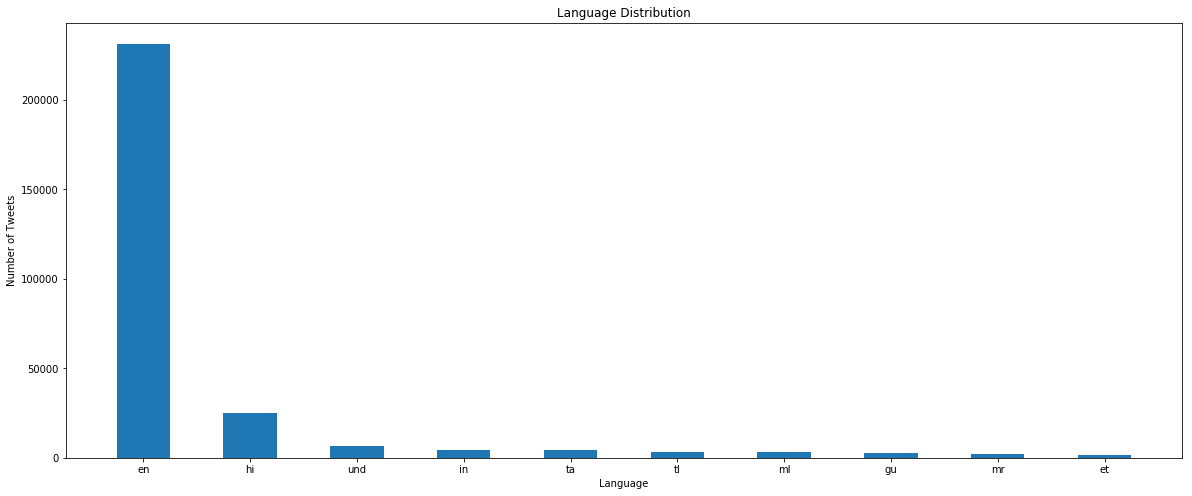

In [23]:
plot_counter(df['lang'], num_elements=10, xlabel="Language", ylabel="Number of Tweets", title="Language Distribution")

In [24]:
df['created_at'] = pd.to_datetime(df['created_at'])
# Sort by time created
df.sort_values(by=['created_at'], inplace=True)

In [25]:
print(start_date, end_date)

warnings.filterwarnings('ignore')
location_date_dict = interleave_location_and_date(df, start_date, end_date)
warnings.filterwarnings('default')

2019-02-23 00:00:00 2019-04-15 00:00:00


### Current Features
   * Number of tweets each day
   * Average pos, neg, neu and compound features
   * Tweet count with neg sentiment

### TODO
   * Hate speech
   * Violent speech

In [26]:
location_features_dict = {}
for location in location_date_dict:
    location_features_dict[location] = get_features(location_date_dict[location])
    print(location, "done")

Sangrur done
Patiala done
Jalandhar done
Amritsar done
Ludhiana done
Chandigarh done
Bathinda done
Bengaluru done
Delhi-New Delhi done
India done
Karnal done
Gurgaon done
Thiruvananthapuram done
Dehradun done
Lucknow done
Pulwama done
Hyderabad done
Kolkata done
Ahmedabad done
Guwahati done
Chennai done
Salem done
Tiruchirappalli done
Coimbatore done
Madurai done
Puducherry done
Agartala done
Imphal done
Jammu done
Ranchi done
Shimla done
Patna done
Jaipur done
Srinagar done
nan done


In [38]:
make_predictions(location_features_dict, labels)

|      Location      |   Train Accuracy |   Test Accuracy |   Precision |   Recall |   F1 Score |   % of +'s in data |
|:------------------:|-----------------:|----------------:|------------:|---------:|-----------:|-------------------:|
|      Agartala      |             0.97 |            0.5  |        0.5  |     1    |       0.67 |              71.11 |
|     Ahmedabad      |             0.91 |            0.83 |        0    |     0    |       0    |              42.22 |
|      Amritsar      |             1    |            0.58 |        0.58 |     1    |       0.74 |              88.89 |
|      Bathinda      |             1    |            0.17 |        0.17 |     1    |       0.29 |              77.78 |
|     Bengaluru      |             1    |            0.5  |        0.5  |     1    |       0.67 |              77.78 |
|     Chandigarh     |             1    |            0.08 |        0.08 |     1    |       0.15 |              73.33 |
|      Chennai       |             1    |       